<a href="https://colab.research.google.com/github/khpankiv/Kaggle_learning/blob/normalization/ell_feedback_regres_1_output.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Setup**

In [1]:
# A dependency of the preprocessing for BERT inputs
#!pip install -q -U "tensorflow-text==2.8.*"

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import matplotlib.pyplot as plt

2022-12-21 17:36:55.568448: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-12-21 17:36:55.568506: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# **Read the datasets**

In [3]:
#! cp /mnt/c/users/Khrystyna/Downloads/kaggle.json ~/.kaggle/
#! chmod 600 ~/.kaggle/kaggle.json

In [4]:

#test= pd.read_csv("./ELL/test.csv")
#test_sub=pd.read_csv("./ELL/sample_submission.csv")

In [30]:
train= pd.read_csv("./ELL/train.csv")
train = train.sample(frac = 0.2)
test = train.iloc[:,0:2]
test_sub = train.iloc[:,[0,2]]

In [31]:
print(train.shape)

(782, 8)


Data preprocessing: changing grades into integer

In [32]:
num_text = train.shape[0]
#batch_size = 32
#num_baches = round(num_text/batch_size)
#num_text = num_baches*batch_size
columns = ['text_id','cohesion']
train_X = train[:].full_text.values
#np.reshape(train_X,(batch_size,num_baches))
train_Y_n = (train.iloc[:,2].values)*2-2
#np.reshape(train_Y_n,(batch_size,num_baches))
#train_Y = tf.keras.utils.to_categorical(train_Y_n)
train_Y = train_Y_n
test_X = train_X
test_id = test.text_id.values
test_Y = (train.iloc[:,2].values)
#np.reshape(test_Y,(batch_size,num_baches))

In [33]:
distribution = train['cohesion']. value_counts(1).sort_index()
#distr=distribution.values
distr = dict(zip(range(9), 1/distribution.values))

# **Define the model**
A simple fine-tuned model, with the preprocessing model, the selected BERT model, one Dense with Softmax output and a Dropout layer.

Add BERT models

In [9]:
tfhub_preprocess = "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3"
tfhub_encoder = "https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4"

In [10]:
  #preprocess_model = hub.KerasLayer(tfhub_preprocess)
  #encoder_inputs = preprocess_model(train_X)
  #encoder = hub.KerasLayer(tfhub_encoder, trainable=False)
  #outputs = encoder(encoder_inputs)
  #output = outputs['pooled_output']

In [11]:
#input_shape = output.shape[1]

In [20]:
batch_size = 1

In [63]:
def build_classifier_model(activ,num_output):
  text_input = tf.keras.layers.Input(shape = (),batch_size = batch_size, dtype=tf.string, name = 'text')
  preprocessing_layer = hub.KerasLayer(tfhub_preprocess)
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_encoder, trainable=False)
  outputs = encoder(encoder_inputs)
  output_not_normalized = outputs['pooled_output']
  normalization = tf.keras.layers.Normalization(mean = 0, variance = 1)
  output = normalization(output_not_normalized)
  output = tf.keras.layers.Dense(256,activation='ReLU')(output)
  #output = tf.keras.layers.Dense(128, activation='ReLU')(output)
#  output = tf.keras.layers.Dense(64, activation='ReLU')(output) 
  output = tf.keras.layers.Dense(32, activation='ReLU')(output)
 # output = tf.keras.layers.Dense(16, activation='ReLU')(output)
  output = tf.keras.layers.Dense(32, activation='ReLU')(output)
#net_1 = tf.keras.layers.Dropout(0.1)(output_2)
  net_1 = tf.keras.layers.Dense(num_output, activation = activ)(output)
  return tf.keras.Model(text_input, net_1)

In [64]:
classifier_model = build_classifier_model('linear',1)

# **Model training**

In [65]:
epochs = 3
#loss = tf.keras.losses.MeanSquaredError(reduction = 'auto')

In [16]:
   # from google3.third_party.tensorflow.core.protobuf import rewriter_config_pb2
    #    config_proto = tf.ConfigProto()
#    off = rewriter_config_pb2.RewriterConfig.OFF
 #   config_proto.graph_options.rewrite_options.arithmetic_optimization = off
  #    session = tf.Session(config=config_proto)

In [66]:
classifier_model.compile(optimizer = 'adam',
                         loss = 'mse',
                         metrics = 'mse')

In [67]:
history = classifier_model.fit(x = train_X,
                               y = train_Y,
                               epochs = epochs,
                               batch_size=batch_size, 
                               class_weight = distr)

Epoch 1/3
782/782 [==============================] - 257s 318ms/step - loss: 72.2305 - mse: 4.6552
Epoch 2/3
782/782 [==============================] - 250s 320ms/step - loss: 62.9184 - mse: 4.6059
Epoch 3/3
782/782 [==============================] - 234s 299ms/step - loss: 78.3467 - mse: 2.8023


# **Model evaluation**

In [57]:
history_dict = history.history
print(history_dict.keys())

dict_keys(['loss', 'mse'])


/tmp/ipykernel_4856/1484422864.py:6: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2,1,1)


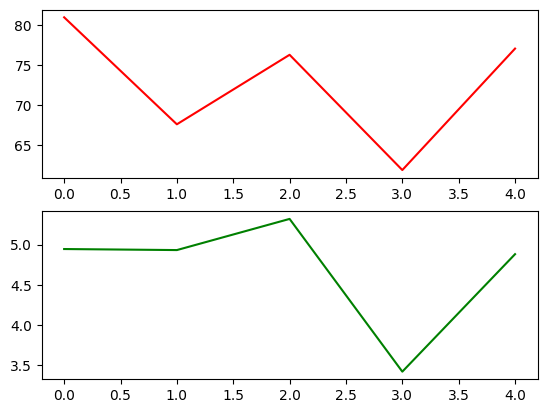

In [58]:
i = range(epochs)
plt.figure(1)
plt.title('Model evaluation')
plt.legend()

plt.subplot(2,1,1)
plt.plot(i,history_dict['loss'],'r',label = "Training loss")

plt.subplot(2,1,2)
plt.plot(i,history_dict['mse'],'g',label = "Training MSE")



In [ ]:
#t = test_X[0:5]

In [68]:
test_Y_n = classifier_model.predict(test_X,verbose = 1)

25/25 [==============================] - 133s 5s/step


In [ ]:
#print(test_Y_n)

In [69]:
pred_test_Y=(np.argmax(test_Y_n,1)+2)/2
pred_Y=np.transpose(pred_test_Y)

In [61]:
print(pred_test_Y)

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.

In [70]:
mcrmse_test = (1/(np.sqrt(num_text)))*np.sum(np.sqrt(np.sum(np.square(pred_Y-test_Y),axis=0)))
print('MCRMSE = ',mcrmse_test) 

MCRMSE =  2.238425757563284


MCRMSE =  0.617284905504784 5 epochs

MCRMSE =  0.6333342304873718 10 epochs

MCRMSE =  0.6012389019459027 10 epochs bached 32

MCRMSE =  0.6137303634466796 5 epochs batched tuned

MCRMSE =  0.5939521873178615 5 epochs 2 dense
  
MCRMSE =  0.5827963961318415 10 epochs 5 dense

MCRMSE =  0.47713642331475004  1 epoch 3 dense shaped

# **create output file**

In [ ]:
#np.reshape(pred_Y,(num_text))
result = [test_id, pred_Y]
df_result = pd.DataFrame(np.transpose(result),columns = columns)

clear the /kaggle/working

In [ ]:
print(num_text)

In [ ]:
i = range(num_text)
plt.plot(i,df_result['cohesion'])

In [ ]:
№df_result.to_csv('/kaggle/working/submission.csv')